# Introduction and basic usage of the NCrystal Python API

This notebook describes the basic typical usage of NCrystal Python API, and lays the foundation for further more detailed tutorials.

## Preamble
Install dependencies and prepare plots. Feel free to edit as you wish:

In [1]:
#By default we only do pip installs on Google Colab, but you
#can set the variable in the next line to True if you need it:
always_do_pip_installs = False
try:
    import google.colab as google_colab
except ModuleNotFoundError:
    google_colab=None#not on google colab
if always_do_pip_installs or google_colab:
    from importlib.util import find_spec as _fs
    if not _fs('NCrystal'):
        %pip -q install ncrystal ipympl numpy matplotlib
#enable inline and interactive matplotlib plots:
if google_colab:
    google_colab.output.enable_custom_widget_manager()
%matplotlib ipympl
import matplotlib
matplotlib.rcParams.update({"figure.autolayout": True})
#always import NCrystal:
import NCrystal as NC
assert NC.version_num >=  3009007, "too old NCrystal found"
NC.test() #< quick unit test that installation works

Tests completed succesfully


## Using basic NCrystal objects
Jumping right into it, let us load a material defined by a *cfg-string* and plot the cross sections. Most often, a cfg-string is a data file name, and perhaps some parameters - like for setting the temperature:

In [2]:
mat = NC.load('Al_sg225.ncmat;temp=10C')

In reality, the `NC.load` call in the previous line has actually combined into `mat` three kinds of NCrystal objects, that together provides all the information and capabilities that NCrystal provides for that material: An `Info` object, a `Scatter` object and an `Absorption` object. The `Info` object provides general information about the material like density and composition, as well as details about the static structure and dynamics of the material. The `Scatter` and `Absorption` objects provides algorithms concerning neutron interactions in the material. The `mat` object itself contains a few convenience utilities. For instance, we can inspect neutron cross section values:

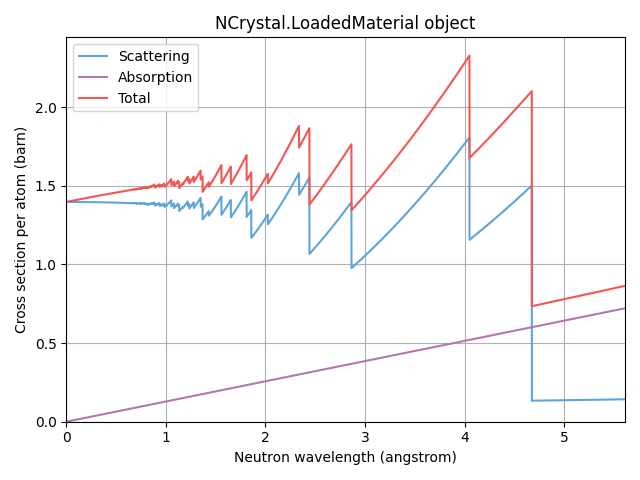

In [3]:
mat.plot()

The entire Python API of NCrystal is enriched with doc-strings for inline help, let us learn more about this `mat` material object:

In [4]:
help(mat)

Help on LoadedMaterial in module NCrystal.core object:

class LoadedMaterial(builtins.object)
 |  LoadedMaterial(cfgstr)
 |
 |  This convenience class combines loaded Info, Scatter, and Absorption
 |  objects of the same material.
 |
 |  Methods defined here:
 |
 |  __init__(self, cfgstr)
 |      Instantiate from a cfg-string which will be passed to the createInfo,
 |      createScatter, and createAbsorption functions.
 |
 |      As a special case, one can also pass a TextData object to this function,
 |      and it will be loaded as by calling the directLoad(..)
 |      function. Likewise, python strings beginning with 'NCMAT' and containing
 |      at least one newline, will also be assumed to be raw NCMAT data and
 |      loaded accordingly. For more control, however, the .directLoad function
 |      is recommended.
 |
 |  __repr__(self)
 |      Return repr(self).
 |
 |  __str__(self)
 |      Return str(self).
 |
 |  dump(self, verbose=0)
 |      Convenience method for print informa

Indeed, we can see that there are essentially `.info`, `.absorption`, and `.scatter` objects as properties as well as convenience methods `.plot()`, `.dump()`, `.xsect(..)` and `.macroscopic_xsect(..)`. The two latter sums up cross sections of the `.absorption` and `.scatter` objects. We check that we can access the more fundamental objects:

In [5]:
print( mat.info )
print( mat.scatter )
print( mat.absorption )

And here we request a brief printout of the three objects:

In [6]:
mat.dump()


>>> Material info:

----------------------------------------------------------------------------------------------------
------------------------------------   NCrystal Material Info   ------------------------------------
----------------------------------------------------------------------------------------------------
Data source: Al_sg225.ncmat
----------------------------------------------------------------------------------------------------
Density : 2.69865 g/cm3, 0.0602324 atoms/Aa^3
----------------------------------------------------------------------------------------------------
Composition (by mole): 100% Al
----------------------------------------------------------------------------------------------------
Composition (by mass): 100% Al
----------------------------------------------------------------------------------------------------
Atom data:
   Al = Al(cohSL=3.449fm cohXS=1.49485barn incXS=0.0082barn absXS=0.231barn mass=26.9815u Z=13)
-----------------------------

The `NC.load(..)` method is merely a convenience method for interactive work. If you only need a particular object you can instead call `createInfo`. `createScatter` or `createAbsorption` directly:

In [7]:
info_Al = NC.createInfo('Al_sg225.ncmat')
info_Al.dump()

----------------------------------------------------------------------------------------------------
------------------------------------   NCrystal Material Info   ------------------------------------
----------------------------------------------------------------------------------------------------
Data source: Al_sg225.ncmat
----------------------------------------------------------------------------------------------------
Density : 2.69865 g/cm3, 0.0602324 atoms/Aa^3
----------------------------------------------------------------------------------------------------
Composition (by mole): 100% Al
----------------------------------------------------------------------------------------------------
Composition (by mass): 100% Al
----------------------------------------------------------------------------------------------------
Atom data:
   Al = Al(cohSL=3.449fm cohXS=1.49485barn incXS=0.0082barn absXS=0.231barn mass=26.9815u Z=13)
--------------------------------------------------

If you are interested in getting a bit more info, you can increase the verbosity (up to 2). This will affect the HKL listing and (for very complex materials) the list of atom positions:

In [8]:
info_Al.dump(verbose=1)

----------------------------------------------------------------------------------------------------
------------------------------------   NCrystal Material Info   ------------------------------------
----------------------------------------------------------------------------------------------------
Data source: Al_sg225.ncmat
----------------------------------------------------------------------------------------------------
Density : 2.69865 g/cm3, 0.0602324 atoms/Aa^3
----------------------------------------------------------------------------------------------------
Composition (by mole): 100% Al
----------------------------------------------------------------------------------------------------
Composition (by mass): 100% Al
----------------------------------------------------------------------------------------------------
Atom data:
   Al = Al(cohSL=3.449fm cohXS=1.49485barn incXS=0.0082barn absXS=0.231barn mass=26.9815u Z=13)
--------------------------------------------------

For more rich plotting of cross sections, the `plot_xsects` and `plot_xsect` functions from the `NCrystal.plot` module can be used. For instance, dive into the different scattering cross section components:

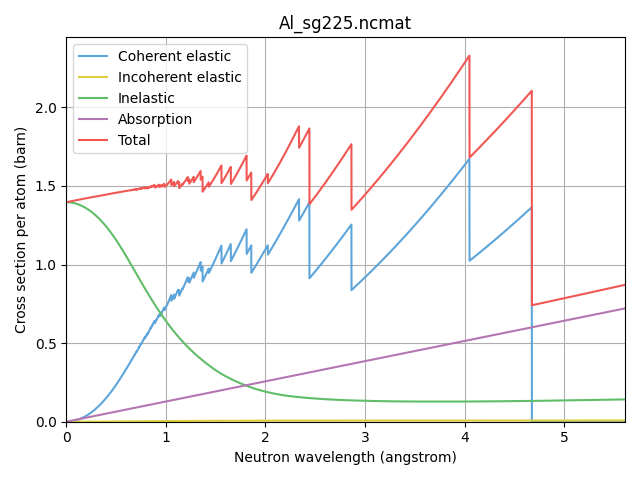

In [9]:
import NCrystal.plot as ncplot
ncplot.plot_xsect('Al_sg225.ncmat')#supply the argument show_absorption=False to hide absorption

Or perhaps you prefer macroscopic cross sections (a.k.a. inverse penetration depth). It is of course just scaled with the number density (atoms/volume) so only the Y-axis scale and text changes:

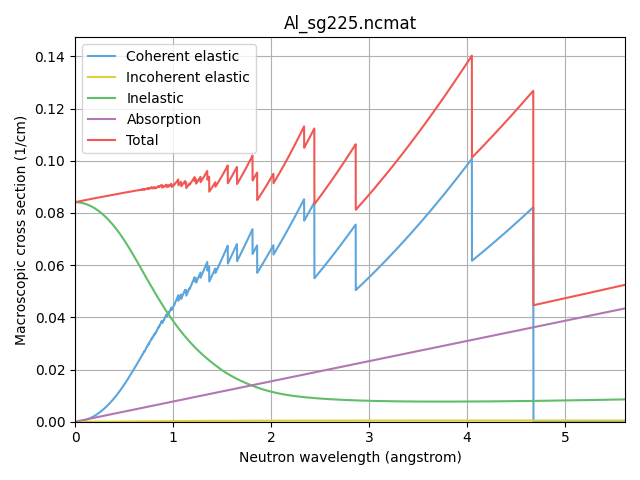

In [10]:
ncplot.plot_xsect('Al_sg225.ncmat',xsmode='macroscopic')

If you wish to overlay different materials and compare cross sections, you have to use the `plot_xsects` (plural `s` at the end) function instead:

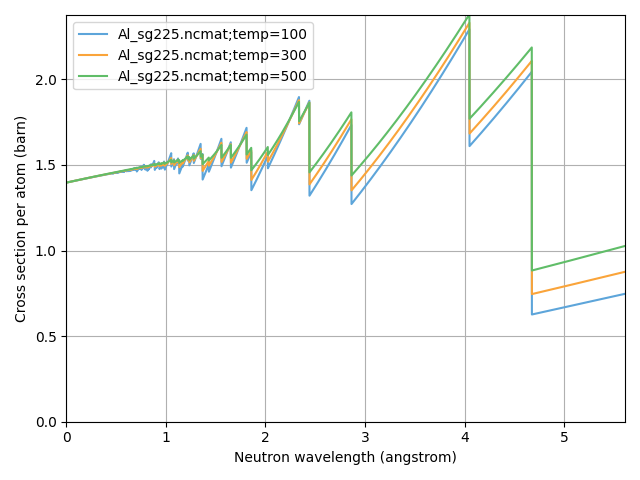

In [11]:
ncplot.plot_xsects('Al_sg225.ncmat;temp=100K',
                   'Al_sg225.ncmat;temp=300K',
                   'Al_sg225.ncmat;temp=500K')

## Simple usage of Scatter or Absorption objects

If you need to extract cross section values, you can do so with the `Scatter` and `Absorption` objects. Note that NCrystal use electronvolt (eV) and angstrom (Å) as default units for energy and lengths respectively:

In [12]:
scatter_Al = NC.createScatter('Al_sg225.ncmat')#NB: default temperature for most materials is 293.15K
print( '%g barn'%scatter_Al.xsect(wl=1.8) )#query at a single neutron wavelength
print( '%g eV'%NC.wl2ekin(1.8) )#NB: ekin2wl exists as well, plus many more conversion fcts in NCrystal.constants module
print( '%g barn'%scatter_Al.xsect(ekin=0.025248212841151512) )#query at a single neutron energy

1.44857 barn
0.0252482 eV
1.44857 barn


We can use numpy arrays as well:

In [13]:
import numpy
wavelengths = numpy.linspace(0.0,10.0,20)
print( wavelengths )
print( scatter_Al.xsect(wl=wavelengths) )

[ 0.          0.52631579  1.05263158  1.57894737  2.10526316  2.63157895
  3.15789474  3.68421053  4.21052632  4.73684211  5.26315789  5.78947368
  6.31578947  6.84210526  7.36842105  7.89473684  8.42105263  8.94736842
  9.47368421 10.        ]
[1.39666864 1.39188337 1.40453992 1.33523631 1.33241165 1.20903676
 1.15591526 1.52057309 1.24379033 0.14075217 0.14597288 0.1522182
 0.15916807 0.16664082 0.17451158 0.18269072 0.19114923 0.19978598
 0.20860266 0.21752032]


To extract single components, we must create a scatter instance with just that component, using the cfg-string parameter `comp` (+changing the temperature to show the usage of multiple parameters):

1.70491 barn


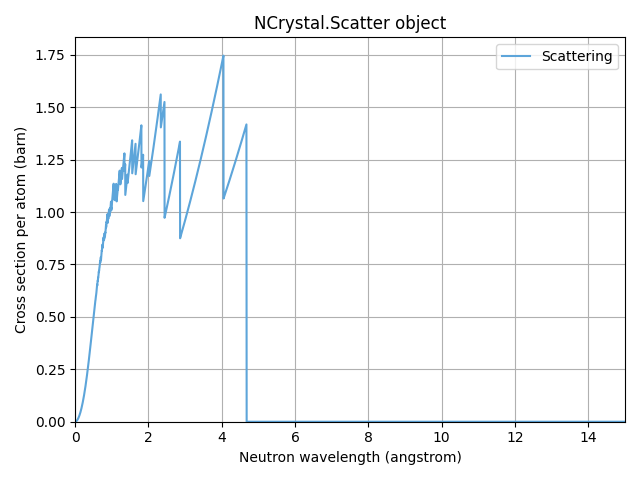

In [14]:
scatter_Al_only_bragg = NC.createScatter('Al_sg225.ncmat;comp=bragg;temp=100K')
print( '%g barn'%scatter_Al_only_bragg.xsect(wl=4.0) )
scatter_Al_only_bragg.plot()

In addition to extracting cross sections with both `Scatter` and `Absorption` objects, one can of course also use a `Scatter` object to perform random sampling of scattering events by using the `.scatter` method. As usual, we can use the builtin `help` function to figure out how:

In [15]:
help(scatter_Al)
help(scatter_Al.scatter)
help(scatter_Al.sampleScatterIsotropic)

Help on Scatter in module NCrystal.core object:

class Scatter(Process)
 |  Scatter(cfgstr)
 |
 |  Base class for calculations of scattering in materials.
 |
 |  Note that kinetic energies are in electronvolt and direction vectors are
 |  tuples of 3 numbers.
 |
 |  Method resolution order:
 |      Scatter
 |      Process
 |      RCBase
 |      builtins.object
 |
 |  Methods defined here:
 |
 |  __init__(self, cfgstr)
 |      create Scatter object based on cfg-string (same as using createScatter(cfgstr))
 |
 |  clone(self, rng_stream_index=None, for_current_thread=False)
 |      Clone object. The clone will be using the same physics models and sharing any
 |      read-only data with the original, but will be using its own private copy
 |      of any mutable caches and will get an independent RNG stream. All in
 |      all, this means that the objects are safe to use concurrently in
 |      multi-threaded programming, as long as each thread gets its own
 |      clone. Return value is th

And we can do a little plot of scattering events for a 1.8Å neutron (assuming a very thin material with no multiple scattering):

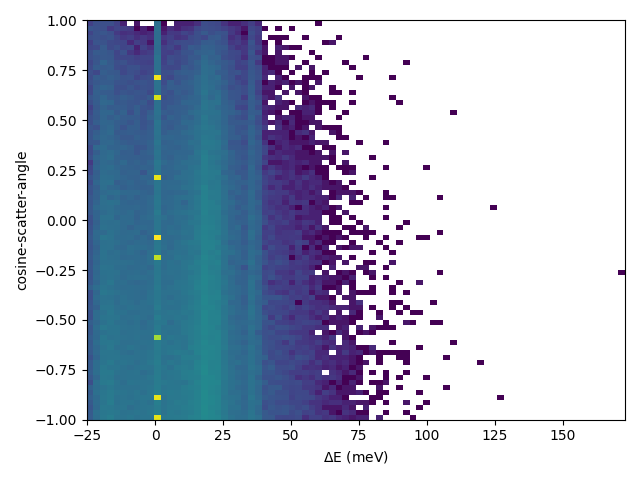

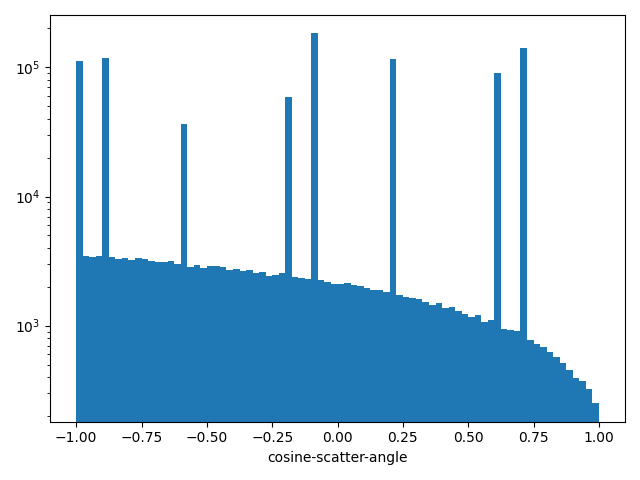

In [16]:
ekin_i = NC.wl2ekin(1.8)
ekin_f, mu = scatter_Al.scatter(ekin=ekin_i,repeat=int(1e6))
import matplotlib
import matplotlib.pyplot as plt
plt.figure()
plt.hist2d((ekin_f-ekin_i)*1000,mu,
           bins=80,
           norm=matplotlib.colors.LogNorm())
plt.ylim(-1,1)
plt.ylabel('cosine-scatter-angle')
plt.xlabel(r'$\Delta$E (meV)')
plt.show()
plt.figure()
plt.hist(mu,bins=80)
plt.semilogy()
plt.xlabel('cosine-scatter-angle')
plt.show()

## Simple usage of Info objects
The `Info` object contain a range of supplementary information about the loaded material. Most notably it includes information about the material density and composition, but other information such as for instance Bragg diffraction structure factors ("HKL lists") or phonon DOS curves, can be access as well. See `help(NC.Info)` for complete details, here we will show a few examples:

In [17]:
info = NC.createInfo('Al2O3_sg167_Corundum.ncmat')

In [18]:
info.dump()

----------------------------------------------------------------------------------------------------
------------------------------------   NCrystal Material Info   ------------------------------------
----------------------------------------------------------------------------------------------------
Data source: Al2O3_sg167_Corundum.ncmat
----------------------------------------------------------------------------------------------------
Density : 3.99122 g/cm3, 0.117867 atoms/Aa^3
----------------------------------------------------------------------------------------------------
Composition (by mole): 60% O 40% Al
----------------------------------------------------------------------------------------------------
Composition (by mass): 47.0748% O 52.9252% Al
----------------------------------------------------------------------------------------------------
Atom data:
   O  = O(cohSL=5.803fm cohXS=4.2317barn incXS=0.0008barn absXS=0.00019barn mass=15.9993u Z=8)
   Al = Al(cohSL=3.4

In [19]:
help(info)

Help on Info in module NCrystal.core object:

class Info(RCBase)
 |  Info(cfgstr)
 |
 |  Class representing information about a given material.
 |
 |  Objects might represent either multi- or single phase
 |  materials. Multi-phase objects contain a list of phases (which might
 |  themselves be either single or multi-phase objects). Most other fields
 |  (structure, hkl lists, dynamics, etc.) are single-phase specific and will
 |  be unavailable on multiphase-phase objects. Exceptions are phase-structure
 |  information (todo) which is only available on multi-phase objects, and
 |  fields which are available for both multi- and single-phase objects such as
 |  density, composition, temperature, and state of matter (where such are well
 |  defined).
 |
 |  Method resolution order:
 |      Info
 |      RCBase
 |      builtins.object
 |
 |  Methods defined here:
 |
 |  __init__(self, cfgstr)
 |      create Info object based on cfg-string (same as using createInfo(cfgstr))
 |
 |  dspacingF

In [20]:
info.composition

[(0.6,
  O=O(cohSL=5.803fm cohXS=4.2317barn incXS=0.0008barn absXS=0.00019barn mass=15.9993amu Z=8)),
 (0.4,
  Al=Al(cohSL=3.449fm cohXS=1.49485barn incXS=0.0082barn absXS=0.231barn mass=26.9815amu Z=13))]

In [21]:
for di in info.dyninfos:
    print(di)

DynamicInfo(O, fraction=60%, type=VDOS, npts=281)
DynamicInfo(Al, fraction=40%, type=VDOS, npts=352)


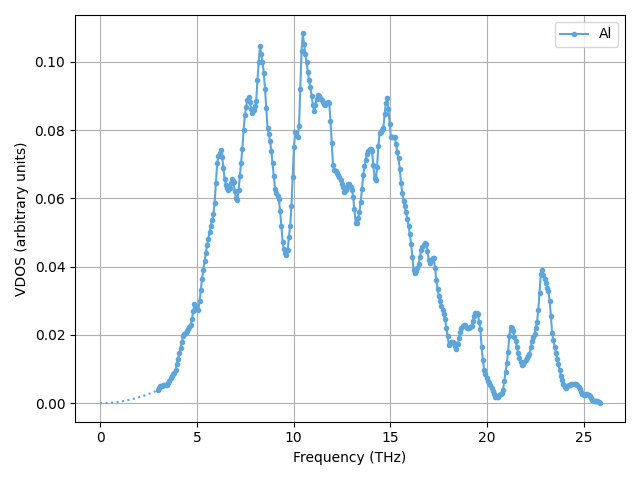

In [22]:
info.findDynInfo('Al').plot_vdos(unit='THz')#default unit is eV

Or, perhaps you want to see the S(alpha,beta) (a.k.a. S(q,omega)) scattering kernel that this phonon DOS expands to?:

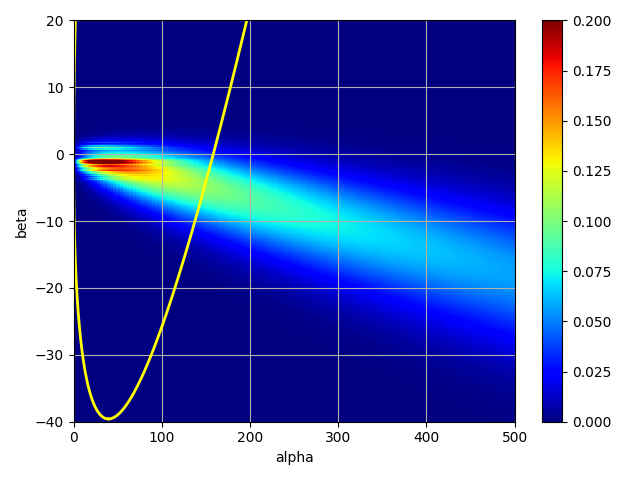

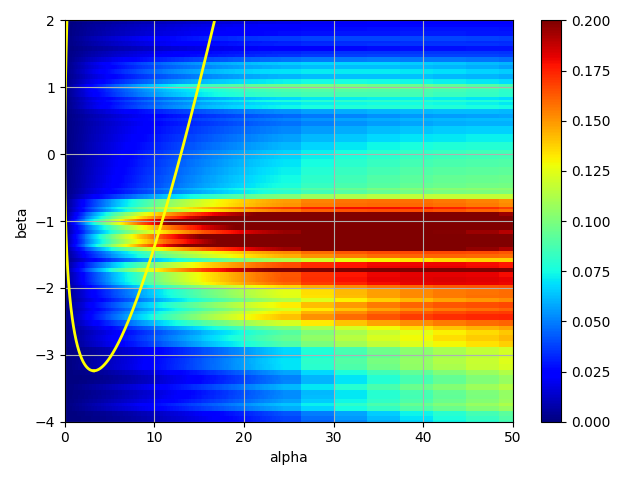

In [23]:
di.plot_knl(clim=(0,0.2),xlim=(0,500),ylim=(-40,20),phasespace_curves=[1.0])#with 1.0eV neutron kinematic limit shown
di.plot_knl(clim=(0,0.2),xlim=(0,50),ylim=(-4,2),phasespace_curves=[NC.wl2ekin(1.0)])#with 1.0Å neutron kinematic limit shown

In [24]:
for ai in info.atominfos:
    print(ai)

AtomInfo(O, 18, DebyeT=994.075K, MSD=0.00347696Aa^2, hasPositions=yes)
AtomInfo(Al, 12, DebyeT=742.637K, MSD=0.00334835Aa^2, hasPositions=yes)


In [25]:
import pprint
pprint.pprint(info.findAtomInfo('Al').positions)

((0.0, 0.0, 0.14782),
 (0.0, 0.0, 0.35218),
 (0.0, 0.0, 0.64782),
 (0.0, 0.0, 0.85218),
 (0.3333333333333333, 0.6666666666666666, 0.018846666666666668),
 (0.3333333333333333, 0.6666666666666666, 0.3144866666666667),
 (0.3333333333333333, 0.6666666666666666, 0.5188466666666667),
 (0.3333333333333333, 0.6666666666666666, 0.8144866666666667),
 (0.6666666666666666, 0.3333333333333333, 0.18551333333333334),
 (0.6666666666666666, 0.3333333333333333, 0.4811533333333333),
 (0.6666666666666666, 0.3333333333333333, 0.6855133333333333),
 (0.6666666666666666, 0.3333333333333333, 0.9811533333333333))


In [26]:
print(info.braggthreshold,'Aa')
print(info.density,'g/cm3')
print(info.numberdensity,'atoms/Aa^3')
print(info.sld,'10^-6/Aa^2')

6.9574242817577385 Aa
3.9912157584832233 g/cm3
0.11786695710760754 atoms/Aa^3
5.729984252829233 10^-6/Aa^2


For the list of HKL reflection planes, one can access them via the `.hklList()` or `.hklObjects()` methods. Note that both of them yield the planes with the longer d-spacings first, so you can always break out of the loop if you wish to forego the planes with shorter d-spacing:

In [27]:
for hkl in info.hklObjects():
    if hkl.d < 2.2:
        break
    print('-----------------------')
    #print the label, d-spacing, structure factor and multiplicity:
    print(hkl)
    #Access values as needed:
    print(f'   d = {hkl.d:g} Aa')
    print(f'   F^2 = {hkl.f2:g} barn')
    print(f'   multiplicity = {hkl.mult}')
    for h,k,l in zip(hkl.h,hkl.k,hkl.l):
        print(f'   hkl = {h}, {k}, {l}')

-----------------------
HKL( hkl_label=(1,0,-2), d=3.47871Aa, F2=4.97203barn, N=6 )
   d = 3.47871 Aa
   F^2 = 4.97203 barn
   multiplicity = 6
   hkl = 1, -2, 0
   hkl = 1, 2, -1
   hkl = 0, 2, 1
-----------------------
HKL( hkl_label=(1,0,4), d=2.5501Aa, F2=5.6695barn, N=6 )
   d = 2.5501 Aa
   F^2 = 5.6695 barn
   multiplicity = 6
   hkl = 1, 4, 0
   hkl = 1, -4, -1
   hkl = 0, -4, 1
-----------------------
HKL( hkl_label=(2,-1,0), d=2.3785Aa, F2=0.82099barn, N=6 )
   d = 2.3785 Aa
   F^2 = 0.82099 barn
   multiplicity = 6
   hkl = 2, 0, -1
   hkl = 1, 0, 1
   hkl = 1, 0, -2


As usual we can use the builtin documentation for these objects (using the `next(..)` function to get help for an hkl entry and not for the generator):

In [28]:
help(next(info.hklObjects()))

Help on HKLEntry in module NCrystal._hklobjects object:

class HKLEntry(builtins.object)
 |  HKLEntry(hh, kk, ll, mult, dsp, fsq, hklinfotype, issymeqv)
 |
 |  A group or family of HKL planes, all sharing the same value of d-spacing
 |  and structure factor (fsquared). If .is_symequiv evaluates to True, these
 |  exactly represent a group of symmetry-equivalent planes.
 |
 |  Methods defined here:
 |
 |  __init__(self, hh, kk, ll, mult, dsp, fsq, hklinfotype, issymeqv)
 |      For internal usage only, do not create therse objects manually.
 |
 |  __str__(self)
 |      Return str(self).
 |
 |  ----------------------------------------------------------------------
 |  Readonly properties defined here:
 |
 |  d
 |      The d-spacing value in units of angstrom.
 |
 |  dspacing
 |      The d-spacing value in units of angstrom.
 |
 |  f2
 |      The squared structure factor (F^2) in units of barn.
 |
 |  fsquared
 |      The squared structure factor (F^2) in units of barn.
 |
 |  h
 |      A

## More about cfg-strings
As you have seen, a single NCrystal *cfg-string* like `"somefile.ncmat;par1=val1;par2=val2"` is all that is required to define a material in NCrystal. This is perhaps not very object-oriented or pythonic, but has the advantage that the same string can be used to define a material in a multitude of contexts:

* In Python
* On the command-line
* On a webpage, in an email to a colleage, etc.
* In OpenMC
* In McStas
* In McStasScript
* In Geant4
* ...

Best of all (especially for the NCrystal developers), we can add a new cfg-string parameter without having to update all NCrystal-bindings for OpenMC/McStas/Geant4/... every time. As soon as we add the parameter in NCrystal, all users who have access to the latest NCrystal release, will automatically be able to use the new parameter.

All the parameters are described in the wiki at https://github.com/mctools/ncrystal/wiki/CfgRefDoc but the most important ones are summarised here:

### Most important cfg-parameters

* **Temperature**:
  - Examples: `temp=100`, `temp=100K`, `temp=-10C`, `temp=100F`
  - All materials have a temperature, and it is not always 293.15! The `temp` parameter does exactly what you think it does. By default it assumes the value is in kelvin, but a unit can be added (must be one of `K`, `C`, or `F`.
* **Density**
  - Examples: `density=2.0gcm3`, `density=3.4kgm3`, `density=0.9x`.
  - Also does what you think it does. The last example scales the density by a factor of 0.9.
* **Scattering component toggling**
  - Current recognised component names are `coh_elas` (alias `bragg`), `incoh_elas`, `sans`, and `inelas`. `elas` refers to all components except `inelas`.
  - Syntax: `<compname>=0' (disable component), `comp=<compname1>,..,<compnamen>` (disable all but the listed components.
  - Examples: `...;comp=inelas,sans` (only inelastic and SANS),`...;inelas=0` (without inelastic),`...;inelas=0;comp=inelas` (oups, removed all components)
* **Modify atomic compositions**
  - Examples: `atomdb=H is D`, `atomdb=Al:is:0.9:Al:0.1:Cr`, `atomdb=Si29:28.97649466525u:4.7fm:0.001b:0.101b`, ...
* **Single crystal parameters**:
  - Single crystal models and orientations are primarily controlled by the parameters `mos`, `dir1`, `dir2`, and `dirtol`. Refer to the documentation linked above, and see the example in the next notebook.


For reference, it should be noted that you can also access information about the cfg-string parameters via built-in documentation:
```python
print(NC.generateCfgStrDoc()
```
Or from the command-line (supply `--doc --doc` twice to get full information):
```bash
$> nctool --doc --doc
```

## The nctool (a.k.a. ncrystal_inspectfile) commandline utility
If you are in working in a terminal, the `nctool` or `ncrystal_inspectfile` command (they are the exact same thing, but `nctool` is the future-proof name) provides a convenient interface to a lot of the most common tasks an NCrystal user might need, when composing a cfg-string for their simulation:

* Load the material and do cross section (or scattering) plots or information dumps to the terminal.
  * Investigate the effect of different cfg-parameters.
* Browse available files.
* Extract content of files (including virtual files)
* Quickly unit test an installation

The `nctool` command, **like all NCrystal cmdline tools** contain embedded documentation, accessible by the `--help` flag:

In [29]:
!nctool --help

usage: nctool [-h] [--version] [-d] [--mc SRCCFG GEOMCFG] [--common CFG]
              [--coh_elas] [--incoh_elas] [--sans] [--elastic] [--inelastic]
              [-a] [--phases] [-x [XRANGE]] [--logy] [--liny] [-e] [-p]
              [--test] [--doc] [--dpi DPI] [--cfg] [--plugins] [-b]
              [--extract DATANAME]
              [CFGSTR ...]

The most common usage of this tool is to load input data (usually .ncmat files)
with NCrystal (v3.9.4) and plot resulting isotropic cross sections for thermal
neutrons. This is done by specifying one or more configurations ("cfg-strings"),
which indicates data names (e.g. file names) and optionally cfg parameters
(e.g. temperatures). Specifying more than one configuration, results in a single
comparison plot of the total scattering cross section based on the different
materials. Specifying just a single file, results in a more detailed cross
section plot as well as a 2D plot of generated scatter angles. Other behaviours
can be obtained by 

In [30]:
!nctool --dump "Al_sg225.ncmat;temp=200K"

----------------------------------------------------------------------------------------------------
------------------------------------   NCrystal Material Info   ------------------------------------
----------------------------------------------------------------------------------------------------
Data source: Al_sg225.ncmat
----------------------------------------------------------------------------------------------------
Density : 2.69865 g/cm3, 0.0602324 atoms/Aa^3
----------------------------------------------------------------------------------------------------
Composition (by mole): 100% Al
----------------------------------------------------------------------------------------------------
Composition (by mass): 100% Al
----------------------------------------------------------------------------------------------------
Atom data:
   Al = Al(cohSL=3.449fm cohXS=1.49485barn incXS=0.0082barn absXS=0.231barn mass=26.9815u Z=13)
--------------------------------------------------

In [31]:
#Uncomment if you are OK with launching new windows with plots (and it might not work depending on how you run the notebook, but you can always try to run the command in a terminal window)
#!nctool "Al_sg225.ncmat;temp=200K"

In [32]:
#Uncomment if you are OK with launching new windows with plots (and it might not work depending on how you run the notebook, but you can always try to run the command in a terminal window)
#!nctool "Be_sg194.ncmat;temp=80K" "Be_sg194.ncmat;temp=150K" "Be_sg194.ncmat;temp=300K" --energy

In [33]:
!nctool --browse

==> 132 files from "stdlib" (stdlib, priority=120):
    AcrylicGlass_C5O2H8.ncmat
    AgBr_sg225_SilverBromide.ncmat
    Ag_sg225.ncmat
    Al2O3_sg167_Corundum.ncmat
    Al4C3_sg166_AluminiumCarbide.ncmat
    AlN_sg186_AluminumNitride.ncmat
    Al_sg225.ncmat
    Ar_Gas_STP.ncmat
    Au_sg225.ncmat
    BaF2_sg225_BariumFluoride.ncmat
    BaO_sg225_BariumOxide.ncmat
    Ba_sg229.ncmat
    Be3N2_sg206_BerylliumNitride.ncmat
    BeF2_sg152_Beryllium_Fluoride.ncmat
    BeO_sg186.ncmat
    Be_sg194.ncmat
    Bi_sg166.ncmat
    C_sg194_pyrolytic_graphite.ncmat
    C_sg227_Diamond.ncmat
    CaCO3_sg62_Aragonite.ncmat
    CaF2_sg225_CalciumFlouride.ncmat
    CaH2_sg62_CalciumHydride.ncmat
    CaO2H2_sg164_CalciumHydroxide.ncmat
    CaO_sg225_CalciumOxide.ncmat
    CaSiO3_sg2_Wollastonite.ncmat
    Ca_sg225.ncmat
    Ca_sg229_Calcium-gamma.ncmat
    CeO2_sg225_CeriumOxide.ncmat
    Cr_sg229.ncmat
    Cu2O_sg224_Cuprite.ncmat
    Cu_sg225.ncmat
    Dy2O3_sg206_DysprosiumOxide.ncmat
    Epoxy_Ar

In [34]:
!nctool --extract Al_sg225.ncmat

NCMAT v5
#
# Aluminium (Al, fcc, cubic, SG-225 / Fm-3m)
#
# Under usual conditions this phase exists from 0 to 933K.
#
# Structure converted with ncrystal_onlinedb2ncmat from:
#
#    "Second edition. Interscience Publishers,
#     New York, Cubic closest packed, ccp, structure"
#    Wyckoff R W G (1963)
#    Crystallography Open Database entry 9008460
#    https://www.crystallography.net/cod/9008460.html
#
# This crystal structure is also compatible with structure obtained from:
#
#   https://www.crystallography.net/cod/9012428.html
#   https://www.crystallography.net/cod/9011602.html
#   https://www.crystallography.net/cod/9012002.html
#
# The VDOS curve was extracted by T. Kittelmann using the engauge digitizer
# software from Figure 1 of:
#
#    "First principles phonon calculations in materials science"
#    A. Togo and I. Tanaka, Scripta Materialia 108 (2015) 1-5
#    https://doi.org/10.1016/j.scriptamat.2015.07.021
#
@CELL
  cubic 4.04958
@SPACEGROUP
  225
@ATOMPOSITIONS
  Al   0

## Multiphase materials


Multiphase materials can be composed in cfg-strings from existing materials the following `"phases<...>"` cfg-string syntax, listing the desired phases and their **volume** (not mass) fraction. This is as easy as:
```
   "phases<0.1*PbS_sg225_LeadSulfide.ncmat&0.9*Epoxy_Araldite506_C18H20O3.ncmat>"
```
Cfg-parameters can be applied as always, affecting either a single phase or all phases depending on placement. For instance, in the following (somewhat silly) material the temperature of 300K applies to all phases, while the d-spacing cutoff only affects the aluminium:
```
   "phases<0.25*Al_sg225.ncmat;dcutoff=0.4&0.75*Be_sg194.ncmat>;temp=300K"
```
Note that whitespace is allowed, if you feel it provides a more readable string Also note that the `"phases<>"` syntax has been chosen specifically to support the use-case that one can always override parameters in cfg-strings by appending a simple string to them. For instance appending the string `";temp=400K"` to any cfg-string will override the temperature value - whether or not the cfg-string uses the `"phases<...>"` syntax or not.

For convenience it is also possible to define multiple phases directly inside NCMAT data. Additionally, NCrystal also has framework-level support for SANS physics, which can be thought of as diffraction due to the geometric layouts of the individual phases. We shall see an example in another notebook.

## Single crystal materials
NCrystal supports both isotropic and anisotropic materials. Currently, the only anisotropic models shipped with NCrystal are mosaic single crystals. One is a more generally useful model of Gaussian mosaicity, and the other one is a dedicated one needed to support the special rotated distribution found in pyrolytic graphite (PG). The PG model is automatically enabled when the relevant data file (`C_sg194_pyrolytic_graphite.ncmat`) is used as a single crystal (if not used as a single crystal, it can be used as standard graphite).

Technically, single crystal models are enabled by supplying the material with a mosaic spread (FWHM of the Gaussian mosaicity), and an orientation. The orientation must be specified by providing the coordinates of two vectors in both the crystal space (i.e. the unit cell coordinate system), and the "lab" space (i.e. where the neutron direction is defined). Specifically, we always need the `dir1`, `dir2`, and `mos` to be set, and there are a few other parameters that one might use to fine-tune the models. As always, see the documentation at https://github.com/mctools/ncrystal/wiki/CfgRefDoc .

NCrystal does not provide a simple utility to quickly plot cross sections for anisotropic materials, since the cross sections in general depend on both neutron energy and direction. However, for the case of single crystals used as monochromators, one will often generate *rocking curves*, showing a neutron cross section as a function of incidence angle. If you execute the next code cell below, you will be able to study various monochromator profiles (and then click to the left of the code cell to collapse it and hide the actual code, unless you have a specific interest).

As we can see, the assumption that a monochromator can always be described by a simplistic gaussian is not always very good - especially for neutrons at shorter wavelengths or in monochromators with higher mosaic spreads. Although it should in fairness be noted, that a real monochromator often is accompanied by some sort of angular selection (e.g. a collimator), which makes the plots below appear worse than they are. Still, single crystals can indeed be said to provide rather complicated and interesting cross sections!!

In [35]:
#
# The code in this cell is very long. You are only meant to study it if you
# have a very specific interest in using single crystals, otherwise you should
# simply click on the left to collapse the cell, and instead play with the resulting
# interactive widget!
#
def get_rocking_curve_of_monochromator( *, dataname, hkl, mosaicity_degree, neutron_wl,
                                        only_selected_plane, absorption ):
    """Extract the rocking curve as (delta_angle,xsect), of the given monochromator. We
    assume the give HKL plane has it's normal orthogonal to the monochromator surface, and
    call that the Z axis. If only_selected_plane=True, the curve will have no contributions
    from other planes or non-Bragg physics."""

    #Due to the directional parameters, cfg-strings can get a bit longer than usual when
    #specifying single crystal orientations. Here we first put the material and specify
    #the mosaic spread:
    
    cfgstr = f'{dataname};mos={mosaicity_degree}deg'
    #Let us first put the chosen normal along the Z-axis in the lab:
    cfgstr += ';dir1=@crys_hkl:%i,%i,%i@lab:0,0,1'%hkl
    
    #To completely fix the orientation, we need to provide a second direction as well.
    #For this example we don't care, so we will simply provide a dummy direction. If
    #we specify dirtol=180degrees, then we are effectively telling NCrystal to not
    #complain when it discovers that the angle between dir1 and dir2 is not the same
    #in the crystal and lab systems. Instead NCrystal will instead modify dir2 to a
    #consistent value. Only requirement for this to work is that the dir2 and dir1
    #directions are not parallel. In this simple example function we accomplish
    #that by putting in some silly values:
    cfgstr += ';dir2=@crys_hkl:0.134,0.456,0.6789@lab:0.134,0.456,0.6789'
    cfgstr += ';dirtol=180deg'

    #To figure out the ideal wavelength, we need to know the d-spacing of the chosen
    #reflection plane. Naturally, NCrystal is ready to help:
    d_hkl = NC.createInfo(cfgstr).dspacingFromHKL(*hkl)

    #print(f"Focusing on hkl={hkl} in {filename} with d_hkl={d_hkl:.14g} and neutron wl={neutron_wl}Aa")
    if not neutron_wl < 2*d_hkl:
        print(f'Bragg diffraction on selected plane not possible since neutron_wl>2*d_hkl={2*d_hkl}Å')
        return
    
    if only_selected_plane:
        #Disable other physics, and remove planes not
        #in a narrow range around the selected hkl:
        cfgstr += ';comp=bragg'
        cfgstr += f';dcutoff={(1-1e-9)*d_hkl}'
        cfgstr += f';dcutoffup={(1+1e-9)*d_hkl}'
    
    #print(''.join(cfgstr.splitlines()))
    mat = NC.load(cfgstr)
    selectedhkl = []
    if only_selected_plane:
        for e in mat.info.hklList(all_indices=True):
            selectedhkl += [(h,k,l) for h,k,l in zip(e[0],e[1],e[2])]

    import numpy as np
    mosaicity = mosaicity_degree*np.pi/180.
    thetabragg = np.arcsin( neutron_wl/(2*d_hkl) )
    def xs_of_rocking_angle(rocking_angle):
        th = thetabragg + rocking_angle
        return mat.scatter.xsect( direction=(np.cos(th),0.0,np.sin(th)), wl=neutron_wl)
    rocking_angles = np.linspace(-mosaicity*10,mosaicity*10,1000)
    xs = np.vectorize(xs_of_rocking_angle)(rocking_angles)
    if absorption:
        xs += mat.absorption.xsect(wl=neutron_wl)
    return dict(curve= ((rocking_angles+thetabragg)*180/np.pi,xs),
                hkl=selectedhkl,
                cfgstr=cfgstr,
                dhkl=d_hkl)
    
materials =[('Ge_sg227.ncmat',((1,1,1),(1,1,3),(1,1,5),(3,3,5))),
            ('C_sg194_pyrolytic_graphite.ncmat',((0,0,2),(0,0,4),(0,0,6),(0,0,8))),
            ('Si_sg227.ncmat',((1,1,1),)),
            ('Cu_sg225.ncmat',((1,1,1),(2,2,2),))]

choices=[]
for name,hkls in materials:
    for hkl in hkls:
        choices.append('hkl=%i%i%i %s'%(*hkl,name))
        
from ipywidgets import interact
@interact(mode=choices,
          mosaicity=['0.001 degree','0.1 degree','0.5 degree'],
          neutron_wavelength=['0.8Å','1.8Å','6Å'])
def plot_rocking_curve(mode='',mosaicity='0.1 degree',neutron_wavelength='1.8Å'):
    import matplotlib.pyplot as plt
    plt.figure('sc_rocking_curve')
    plt.clf()
    neutron_wl=float(neutron_wavelength[:-1])
    dataname=mode.split()[1]
    h,k,l=(int(e) for e in mode.split()[0].split('=')[1])
    curve = lambda osp,absn : get_rocking_curve_of_monochromator( dataname=dataname,
                                                             hkl = (h,k,l),
                                                             mosaicity_degree=float(mosaicity.split()[0]),
                                                             neutron_wl=neutron_wl,
                                                             only_selected_plane = osp,
                                                             absorption = absn)
    
    
    c = curve(True,False)
    if not c:
        return
    plt.plot(*c['curve'],label=f'{len(c["hkl"])*2} selected planes with selected d-spacig')
    c_std = curve(False,False)
    plt.plot(*c_std['curve'],label='+Other scattering')
    plt.plot(*curve(False,True)['curve'],label='+Absorption',ls='--',lw=2)
    plt.grid()
    plt.xlabel('Rocking angle (degree)')
    plt.ylabel('cross section (barn)')
    plt.title(mode.replace('.ncmat',''))
    plt.legend()
    plt.show()
    sp = ') ('.join('%i,%i,%i'%p for p in c['hkl'])
    import textwrap
    l=textwrap.wrap('(%s)'%sp,50)
    print('-'*60)
    print('Cfg-string: "%s"'%c_std['cfgstr'])
    print('d-spacing: "%g Å"'%c_std['dhkl'])
    print('Selected planes: %s'%l[0])
    for e in l[1:]:
        print('                 %s'%e)

interactive(children=(Dropdown(description='mode', options=('hkl=111 Ge_sg227.ncmat', 'hkl=113 Ge_sg227.ncmat'…

## References and where to find more information

The available documentation for NCrystal is a work in progress, and while we still didn't consolidate this in one glorious location, there is plenty of information to be found:

* The official wiki: https://github.com/mctools/ncrystal/wiki/
  * This includes the [Data-library](https://github.com/mctools/ncrystal/wiki/Data-library) and [CfgRefDoc](https://github.com/mctools/ncrystal/wiki/CfgRecDoc) pages which most users might need.
  * For advanced users, the offical [NCMAT format specification](https://github.com/mctools/ncrystal/wiki/NCMAT-format) is there as well, along with instructions for usage or development of optional [plugins](https://github.com/mctools/ncrystal/wiki/Plugins).
  * Be sure to check out the various release Announcement pages you find in the sidebar, since a lot of information was described there but still didn't make it anywhere else.
* The Python API contains doc-strings everywhere, accessible though the `help` function. Please use it!
* All command-line tools support a `--help` flag, which will result in usage instructions being printed out.
* For C++ developers: Lots and lots of thorough comments are left everywhere in the code.
* The [README](https://github.com/mctools/ncrystal/blob/master/README) and [INSTALL](https://github.com/mctools/ncrystal/blob/master/INSTALL) files from the NCrystal release itself.
* Publications (also, **please remember to cite if you use NCrystal and want to support us!**):
  * X.-X. Cai and T. Kittelmann, NCrystal: A library for thermal neutron transport, Computer Physics Communications 246 (2020) 106851, https://doi.org/10.1016/j.cpc.2019.07.015
  * T. Kittelmann and X.-X. Cai, Elastic neutron scattering models for NCrystal, Computer Physics Communications 267 (2021) 108082, https://doi.org/10.1016/j.cpc.2021.108082
  * X.-X. Cai, T. Kittelmann, et. al., "Rejection-based sampling of inelastic neutron scattering", Journal of Computational Physics 380 (2019) 400-407, https://doi.org/10.1016/j.jcp.2018.11.043

## How to get help

There are many options for how to get help with NCrystal. We welcome all contact, but given that we are normally stretched for manpower, some means of contact are certainly easier for us to deal with than others!

* **Using the discussion forum for questions or discussions**
  * Our discussions forum at https://github.com/mctools/ncrystal/discussions is where we hope that users of all levels will ask their questions!
  * Do not be afraid to ask "stupid questions". Such questions are rarely actually stupid, but often expose the need for better documentation, or real bugs in our code. Or perhaps all there is needed is another NCrystal user to share the solution they had in a similar situation.
  * Should a question end up exposing a bug (or feature request) for NCrystal, we can also easily convert them to proper GitHub "issues", and include other relevant experts in the discussions.
  * Feel free to use the forum for other NCrystal-related subjects as well.
  * *Please sign up to "watch" the discussions if you are an NCrystal user that want to contribute by helping other users*
* **Reporting bugs or feature requests**
  * Please do so using the tracker at https://github.com/mctools/ncrystal/issues
  * Don't worry if you don't get the meta-data of the request correct, we can fix it up later. Also don't worry if your issue is a valid one or not - we can always simply provide advice and then close the issue.
  * Do try to include as many details as possible about your issue, so we don't have to drag them out of you.
* **Sending emails to NCrystal developers**
  * Of course you can do so, but please consider first if you could not use one of the other manner of contacts above.
  * Emails can be very distracting, since in practice they must be dealt with either "immediately" or "never".
  * We will never be upset at getting emails, but you might get a short reply asking you to post your problem in one of the GitHub channels instead.
